In [11]:
import numpy as np
import CNN.utils as utils
import matplotlib.pyplot as plt

m = 50000
img_dim = 28

X = utils.extract_data('train-images-idx3-ubyte.gz', m, img_dim)
print(X.shape)

Extracting train-images-idx3-ubyte.gz
(50000, 784)


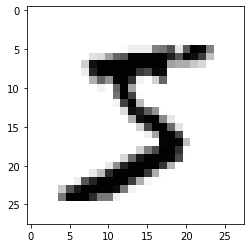

In [13]:
X -= int(np.mean(X))
X /= int(np.std(X))

X = 255 - X

plt.imshow(np.reshape(X[0], (28, 28)), cmap='gray')
plt.show()

In [8]:
y_dash = utils.extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m, 1)
print(y_dash)

Extracting train-labels-idx1-ubyte.gz
[[5]
 [0]
 [4]
 ...
 [8]
 [4]
 [8]]


In [17]:
train_data = np.hstack((X, y_dash))
train_data.shape
train_data[0][-1]

5.0

In [52]:
from CNN.utils import *

batch_size = 32
batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]
batch = batches[0]
print("len(batch) =", len(batch))
print("batch.shape =", batch.shape)
X = batch[:,0:-1]
print("X.shape =", X.shape)
print()

Y = batch[:,-1] # get batch labels

## Initializing all the parameters
num_filt1 = 8
num_filt2 = 8
f = 5
num_classes = 10
lr = 0.01
img_dim = 28
img_depth = 1
beta1 = 0.95
beta2 = 0.99

f1, f2, w3, w4 = (num_filt1, img_depth, f, f), (num_filt2, num_filt1, f, f), (128, 800), (10, 128)
f1 = initializeFilter(f1)
f2 = initializeFilter(f2)
w3 = initializeWeight(w3)
w4 = initializeWeight(w4)

print("f1.shape =", f1.shape)

b1 = np.zeros((f1.shape[0],1))
b2 = np.zeros((f2.shape[0],1))
b3 = np.zeros((w3.shape[0],1))
b4 = np.zeros((w4.shape[0],1))

print("b1.shape =", b1.shape)

params = [f1, f2, w3, w4, b1, b2, b3, b4]

## params, cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
# Step in adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost)
# n_c: number of channels

X = X.reshape(len(batch), img_depth, img_dim, img_dim)
print("X.shape =", X.shape)
print("X[0].shape =", X[0].shape)

i = 0
x = X[i] # shape = (1, 28, 28)
y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
print()
print("y =")
print(y)


## grads, loss = conv(x, y, params, 1, 2, 2)
# Step in conv(image, label, params, conv_s, pool_f, pool_s)
conv_s = 1
pool_f = 2
pool_s = 2

len(batch) = 32
batch.shape = (32, 785)
X.shape = (32, 784)

f1.shape = (8, 1, 5, 5)
b1.shape = (8, 1)
X.shape = (32, 1, 28, 28)
X[0].shape = (1, 28, 28)

y =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    # n_f: number of filters
    # n_c_f: number of channels of each filter
    # f: dimension of each filter
    # ignore the last dimension because filter is a square matrix
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    
    # n_c: number of channels
    # im_dim: dimension of input image
    # ignore the last dimension because input image is a square matrix
    n_c, im_dim, _ = image.shape # image dimensions: (1, 28, 28)
    
    out_dim = int((im_dim - f)/s)+1 # calculate output dimensions

    # image depth must equal filter depth
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f, out_dim, out_dim))
    
    # convolve the filter over every part of the image, adding the bias at each step. 
    # curr_f: filter index: 0, 1, 2, 3, 4, 5, 6, 7
    # curr_y: current y index of the input image matrix: 0, 1, 2, 3, ..., 27
    # curr_x: current x index of the input image matrix: 0, 1, 2, 3, ..., 27
    # out_y: y index of the output matrix: 0, 1, 2, 3, ..., out_dim
    # out_x: x index of the output matrix: 0, 1, 2, 3, ..., out_dim
    # image.shape = (1, 28, 28)
    for i in range(n_f):
        ft = filt[i]

        # go along y
        im_y = out_y = 0
        while im_y + f <= im_dim:

            # go along x
            im_x = out_x = 0
            while im_x + f <= im_dim:
                region = image[:, im_y:(im_y + f), im_x:(im_x + f)]
                out[i, out_y, out_x] = np.sum(ft * region) + bias[i]
                im_x += s
                out_x += 1
            im_y += s
            out_y += 1
        
    return out

# f1.shape = (8, 1, 5, 5)
# b1.shape = (8, 1)
conv1 = convolution(x, f1, b1, conv_s) # convolution operation

(8, 24, 24)


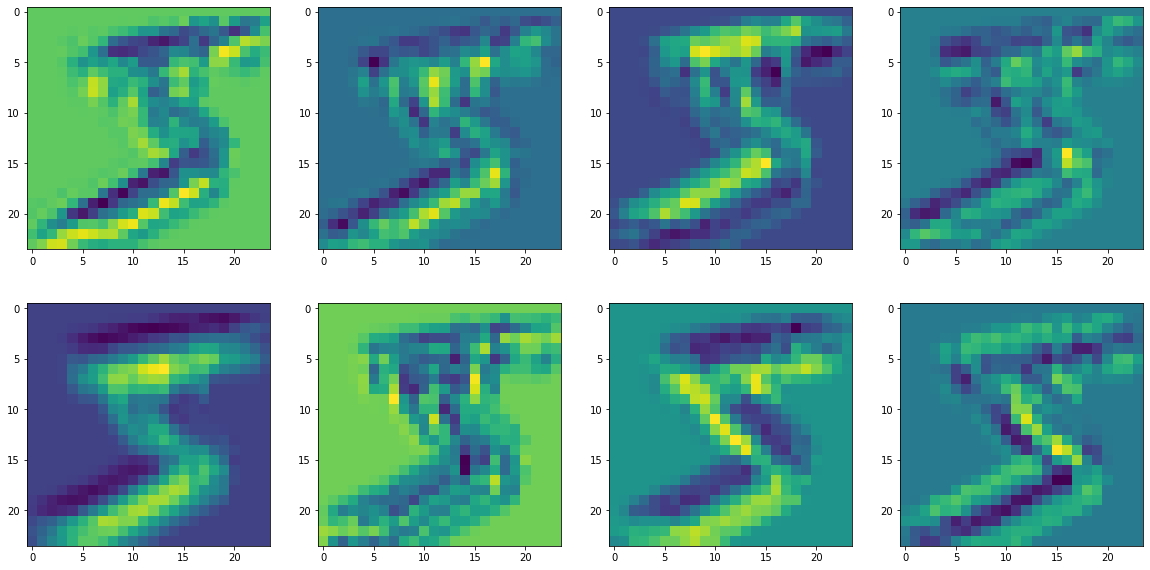

In [61]:
print(conv1.shape)
fig = plt.figure(figsize=(20, 10))
for i in range(f1.shape[0]):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(conv1[i])
plt.show()

In [ ]:
def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled
